# Analysis 2: Cookie cats A/B test results

## Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import duckdb

## Contex

The dataset includes A/B test results of Cookie Cats game to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.\
Data source: Kaggle (https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats)

## Content

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid: A unique number that identifies each player.
version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).\
sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.\
retention_1: Did the player come back and play 1 day after installing?\
retention_7: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was **randomly** assigned to either.

## GOAL: Evaluating whether changing the first gate in the Cookie Cats to gate_40 would encourage players to play Cookie Cat more often.

### Dataset overview
Fragment of A/B test results in a dataset below:

In [2]:
ABtest_30vs40_df = pd.read_csv("cookie_cats.csv")
ABtest_30vs40_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
ABtest_30vs40_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


- dataset has no null elements
- 3 different features might be taken into account while analyzing the results


### Target metric
3 target metrics would be taken into account in order to measure progress towards the goal:
- **Average game rounds per player**: checks if changing first gate in the Cookie Cats encourage players to play more rounds.
- **Sum of players who logged in 1 day after installation**: check how changing first gate in the Cookie Cats encourage players to play the game right after installation (short term)?
- **Sum of players who logged in 7 days after installation** check how changing first gate in the Cookie Cats encourage players to play the game in week after installation (mid term)?

#### Sample size in groups

Because players were randomly assigned to test group, number of players in each group should be equal. Sample size is an important metric which indicates which statistic test to choose and how much power will there be in testing.\
Sample size is also crucial in order to check correct random assignment.

In [4]:
query = """
SELECT version, COUNT(*) Sample_size
FROM ABtest_30vs40_df
GROUP BY 1
"""

Sample_size_df = duckdb.query(query).df()
Sample_size_df

,version,Sample_size
0,gate_30,44700
1,gate_40,45489


Saving the sample size for each group

In [5]:
N_gate_30 = int(Sample_size_df.loc[0, "Sample_size"])
N_gate_40 = int(Sample_size_df.loc[1, "Sample_size"])

## Checking Invariants
Assuming that each user was randomly assigned to a control or experimental group, theoretical probability must be around 0.5 (Sample size is an invariant metric)\
How much the number of user assigned, differ between groups? 

$H_0$: N_gate_30 = N_gate_40\
$H_a$: N_gate_30 $\neq$  N_gate_40\
$\alpha$ = 0.05

### A. Binomial Confidence Interval
Since number of samples is high (N>30), we can assume normal distribution of samples. Additionally there are only two groups in which users were assigned, so we can calculate Binomial Confidence Interval:
1. Calculating the real proportion of samples in control group (gate_30/all samples) 
2. Calculating standard deviation of binomial with probability 0.5 of success
3. Calculating margin of error with Z* for 95% confidence
4. Calculating lower and upper confidence interval boundaries

In [11]:
P = N_gate_30 / (N_gate_30 + N_gate_40)  # real proportion
SD = ((0.5 * 0.5) / (N_gate_30 + N_gate_40) )**1/2 # standard deviation
m = 1.96 * SD  # margin of error
CI_upper = 0.5 + m
CI_lower = 0.5 - m
print(f"CI lower: {CI_lower}")
print(f"CI upper: {CI_upper}")
print(f"Real group proportion: {P}")

CI lower: 0.4999972834824646
CI upper: 0.5000027165175354
Real group proportion: 0.49562585237667567


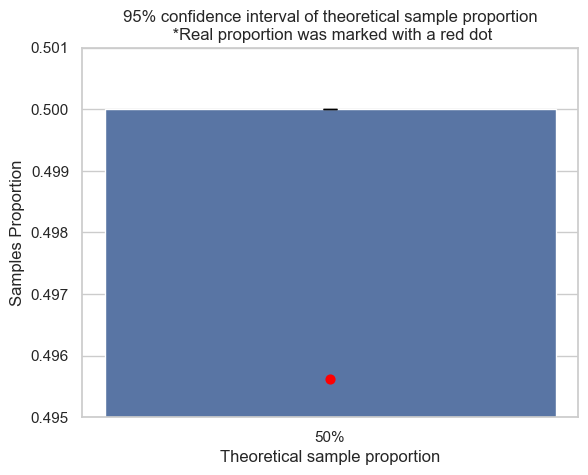

In [12]:
sns.despine(left=True, bottom=True);
sns.set_theme(style="whitegrid");

CI_error_plot = sns.barplot({"50%": [0.5]})
plt.errorbar(x=0, y=0.5, yerr=[m], fmt="none", c="black", capsize=5)
plt.ylim([0.495, 0.501])
plt.scatter(0, P, color="red", s=40)
CI_error_plot.set(
    title=f"95% confidence interval of theoretical sample proportion\n *Real proportion was marked with a red dot",
    ylabel="Samples Proportion",
    xlabel="Theoretical sample proportion",
);

With confidence of 95% the fraction of users should fall within range  0.499995 and 0.5000054.
The real proportion (0.4956) is beyond confidence interval. $H_0$ is rejected.

### B. Chi-square test


In [8]:
chisquare([N_gate_30, N_gate_40])

Power_divergenceResult(statistic=6.9024049496058275, pvalue=0.008607987810836262)

If the assignment of users were truly random, the probability that these groups sizes would occur by chance is 0.0086 which is lower than 1%! $H_0$ is rejected.

## Conclusions
Checking Invariants failed.

It might be caused by technical problems while assigning users in groups: Eg.:
- Wrong experiment infrastructure, 
- wrong experiment set up, 
- wrong data capture etc.

There is no basis for further analysis because results will be biased.


## Next steps 
A. Contacting with Data Engineer Department and trying to debug the experiment\
B. Using Pre and Post-periods in test recreation - Does the same problem appear in earlier or latter data?
